<a href="https://www.kaggle.com/code/hetarthchopra/neural-network-feature-selection?scriptVersionId=114211294" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


This notebook is just a code run through for the tutorial at https://captum.ai/tutorials/Titanic_Basic_Interpret. 
I have used it to get up to speed with Captum, PyTorch and Model Interpretability. 

Apart from that, I will be building a model with all the features first, and then I will try to increase the accuracy after removin the less important features using Integrated Gradients Approach

In [2]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
import torch.nn as nn

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
!matplotlib.inline

from scipy import stats
import pandas as pd

/bin/bash: matplotlib.inline: command not found


In [4]:
# read the dataset
titanic_data = pd.read_csv('/kaggle/input/titanic/train.csv')
# do one hot encoding
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['Sex']),
                          pd.get_dummies(titanic_data['Embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['Pclass'],prefix="pclass")], axis=1)
titanic_data["Age"] = titanic_data["Age"].fillna(titanic_data["Age"].mean())
titanic_data["Fare"] = titanic_data["Fare"].fillna(titanic_data["Fare"].mean())
titanic_data = titanic_data.drop(['Name','Ticket','Cabin','Sex','Embarked','Pclass','PassengerId'], axis=1)

In [5]:
titanic_data.head()

,Survived,Age,SibSp,Parch,Fare,female,male,embark_C,embark_Q,embark_S,pclass_1,pclass_2,pclass_3
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [6]:
#set random seed for reproducibility
np.random.seed(100)

# convert all to numpy
labels = titanic_data['Survived'].to_numpy()
titanic_data = titanic_data.drop(['Survived'],axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

In [7]:
# separate train and test data
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

## Build a Baseline Model

In [8]:
torch.manual_seed(1)

# code a neural network with the nn module imported into the class
class Titanic_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12,12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12,8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8,2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        lin1_out = self.linear1(x)
        sigmoid1_out = self.sigmoid1(lin1_out)
        lin2_out = self.linear2(sigmoid1_out)
        sigmoid2_out = self.sigmoid2(lin2_out)
        lin3_out = self.linear3(sigmoid2_out)
        softmax_out = self.softmax(lin3_out)
        return softmax_out

In [9]:
model = Titanic_Model()
criterion = nn.CrossEntropyLoss()
num_epochs = 200

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)
for epoch in range(num_epochs):    
    output = model(input_tensor)
    loss = criterion(output, label_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

Epoch 1/200 => Loss: 0.70
Epoch 21/200 => Loss: 0.65
Epoch 41/200 => Loss: 0.61
Epoch 61/200 => Loss: 0.57
Epoch 81/200 => Loss: 0.51
Epoch 101/200 => Loss: 0.49
Epoch 121/200 => Loss: 0.48
Epoch 141/200 => Loss: 0.47
Epoch 161/200 => Loss: 0.47
Epoch 181/200 => Loss: 0.47


In [10]:
# save the model
torch.save(model.state_dict(), '/kaggle/working/titanic_model.pt')

In [11]:
# evaluate the model and it's accuracy/inaccuracy
out_probs=model(input_tensor).detach().numpy()
out_classes=np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes==train_labels)/len(train_labels))

Train Accuracy: 0.8619582664526485


In [12]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = model(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.7910447761194029


## Calculate the Integrated Gradients

In [13]:
ig = IntegratedGradients(model)

In [14]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor, target = 1, return_convergence_delta  = True)
attr = attr.detach().numpy()

Average Feature Importances
Age :  -0.613
SibSp :  -0.136
Parch :  0.030
Fare :  0.400
female :  0.130
male :  -0.322
embark_C :  0.032
embark_Q :  0.024
embark_S :  -0.033
pclass_1 :  0.095
pclass_2 :  0.048
pclass_3 :  -0.182


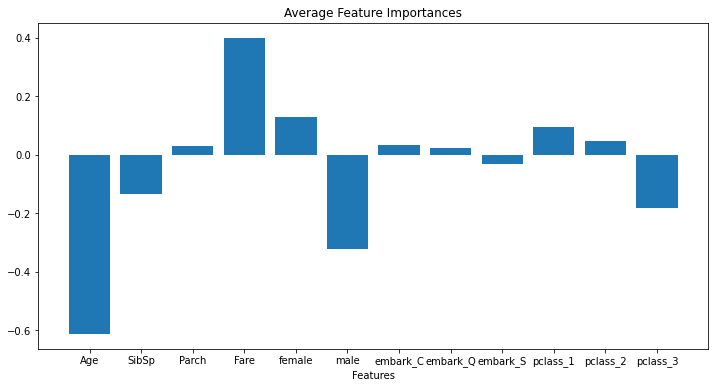

In [15]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

# Make the New Dataset

In [16]:
# do not include variables such as Parch, Embark_C, Embark_Q,Embark_S and others that you feel, which have low feature importance
# read the dataset
titanic_data = pd.read_csv('/kaggle/input/titanic/train.csv')
# do one hot encoding
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['Sex']),
                          pd.get_dummies(titanic_data['Pclass'],prefix="pclass")], axis=1)
titanic_data["Age"] = titanic_data["Age"].fillna(titanic_data["Age"].mean())
titanic_data["Fare"] = titanic_data["Fare"].fillna(titanic_data["Fare"].mean())
titanic_data = titanic_data.drop(['Name','Ticket','Cabin','Sex','Embarked','Pclass','PassengerId','Parch'], axis=1)

In [17]:
# convert all to numpy
labels = titanic_data['Survived'].to_numpy()
titanic_data = titanic_data.drop(['Survived'],axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

In [18]:
# separate train and test data
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

## Retrain model with different dataset

In [19]:
torch.manual_seed(1)

# code a neural network with the nn module imported into the class
class Titanic_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(8,12) # since features have been dropped chaneg input layer
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12,8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8,2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        lin1_out = self.linear1(x)
        sigmoid1_out = self.sigmoid1(lin1_out)
        lin2_out = self.linear2(sigmoid1_out)
        sigmoid2_out = self.sigmoid2(lin2_out)
        lin3_out = self.linear3(sigmoid2_out)
        softmax_out = self.softmax(lin3_out)
        return softmax_out

In [20]:
model = Titanic_Model()
criterion = nn.CrossEntropyLoss()
num_epochs = 200

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)
for epoch in range(num_epochs):    
    output = model(input_tensor)
    loss = criterion(output, label_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

Epoch 1/200 => Loss: 0.67
Epoch 21/200 => Loss: 0.64
Epoch 41/200 => Loss: 0.60
Epoch 61/200 => Loss: 0.56
Epoch 81/200 => Loss: 0.50
Epoch 101/200 => Loss: 0.49
Epoch 121/200 => Loss: 0.48
Epoch 141/200 => Loss: 0.48
Epoch 161/200 => Loss: 0.47
Epoch 181/200 => Loss: 0.47


In [21]:
# evaluate the model and it's accuracy/inaccuracy
out_probs=model(input_tensor).detach().numpy()
out_classes=np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes==train_labels)/len(train_labels))

Train Accuracy: 0.8443017656500803


In [22]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = model(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.8246268656716418


# # # *We can see from here that the Test Accuracy increases as we use less features after feature selection.*